# Lecture 6: Learning hyperparameters for GP. Active learning and Bayesian optimization.

## How to explore the function of interest via GP process?

### Setting
* Suppose that we have $n$ evaluations of our function of interest $y = f(\mathbf{x}) + \varepsilon$, $ \varepsilon\sim\mathcal N(0,\sigma^2)$:

$$
\mathcal D_{n} = \{(\mathbf{x}_i,y_i),\; i = 1,\ldots,n\}.
$$
* And we want to know which points $\mathbf{x}_{n+1},\mathbf{x}_{n+2},\ldots$ we should sample and evaluate the function in order to find maximum/minimum of $f(\mathbf{x})$ or reduce an approximation error.

### Bayesian optimization (general algorithm)
1. **for** $t=n+1,\,n+2,\ldots$
2. Find $\mathbf{x}_t$ by combining attributes of the posterior distribution in a **utility function** $u(x \mid \mathcal D_{t-1})$ and maximizing: $x_t = \text{argmax}_\mathbf{x} u(\mathbf x\mid\mathcal D_{t-1})$.
3. Sample the function $y_t = f(\mathbf{x}_t) + \varepsilon_t$.
4. Augment the data $\mathcal D_t = \{D_{t-1},(\mathbf{x}_t,y_t)\}$ and update the GP.
5. **end for**

### Exploration-exploitation trade-off

* In order to find the maximum, we should choose the next input $\mathbf{x}$ where the mean $\mu(\mathbf{x})$ is high (exploitation) and the variance $\sigma(\mathbf{x})$ is high (exploration) as well.
* This trade-off is accounted in the **acquisition** (or **utility**) function. The simplest utility function is $\mu(\mathbf{x})+\alpha\cdot\sigma(\mathbf{x})$. 
* If we need to explore (not find the max or min) the function of interest, then the utility function is just a value of standard deviation of GP $u(\mathbf x\mid\mathcal D_{t-1}) = \sigma(\mathbf{x})$ 
* Popular utility functions: **probability of improvement**, **expected improvement**, **GP-UCB**, **Thompson sampling**.  

* In the example below, we explore the function of interest 
$$
f(x)=\frac12\cos(2x)+\sin(0.9x)
$$
with the use of GPR for two sampling approaches: random and adaptive with maximization of s.d. as a utility function. Also, approximation error is considered and compared.

* We can change 4 parameters: $\ell$ is the correlation length, $N$ and $n$ are the number of training and test points, correspondingly, $\sigma$ is the amount of noise at each point.

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
from ipywidgets import interactive, interact, widgets
import scipy.spatial as SP

from scipy.stats import norm


def GP(length_scale, n, N, sigma, mode):
    # mode: if 0 -- active learning, if 1 -- random selection
    np.random.seed(42)

    Xtest = np.linspace(-5, 5, n)[:, None]

    def f(x): return 0.5*np.cos(2*x.flatten())+np.sin(0.9*x.flatten())

    def kernel(a, b):
        return np.exp(-.5 * SP.distance.cdist(a, b, 'sqeuclidean')/(length_scale**2))

    def fitting(X, num_of_points):
        y  = f(X) + sigma*np.random.randn(num_of_points)
        K  = kernel(X, X)
        L  = np.linalg.cholesky(K + sigma*np.eye(num_of_points))
        Lk = np.linalg.solve(L, kernel(X, Xtest))
        mu = np.dot(Lk.T, np.linalg.solve(L, y))
        K_ = kernel(Xtest, Xtest)
        s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
        s  = np.sqrt(s2)
        return y, mu, s

    err_act = []
    err_rand = []

    for t in range(1, N+1):
        mu_act = 0
        if t == 1:
            X_act = np.random.uniform(-5, 5, size=(1, 1))
            _, _, s_act = fitting(X_act, t)
            X_act = np.append(
                X_act, Xtest[np.argmax(np.array(s_act))]).reshape(t+1, 1)
        else:
            y_act, mu_act, s_act = fitting(X_act, t)
            X_act = np.append(
                X_act, Xtest[np.argmax(np.array(s_act))]).reshape(t+1, 1)
        X_act = X_act[:N]
        err_act.append(np.linalg.norm(f(Xtest)-mu_act, ord=np.inf) /
                       np.linalg.norm(f(Xtest), ord=np.inf))

    X_rand = np.random.uniform(-5, 5, size=(N, 1))
    y_rand, mu_rand, s_rand = fitting(X_rand, N)
    for t in range(1, N+1):
        mu_rand = 0
        X_rand_t = np.copy(X_rand[:t])
        _, mu_rand, _ = fitting(X_rand_t, t)
        err_rand.append(np.linalg.norm(f(Xtest)-mu_rand,
                                       ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf))

    if mode == 'Adaptive sampling':
        y = y_act
        X = X_act
        mu = mu_act
        s = s_act
    else:
        y = y_rand
        X = X_rand
        mu = mu_rand
        s = s_rand

    plt.figure(1, figsize=(9, 7))
    plt.clf()
    plt.plot(X, y, 'r+', ms=18, label="Training points")
    plt.plot(Xtest, f(Xtest), 'b-', label="Function")
    plt.fill_between(Xtest.flat, mu-s, mu+s, color="#dddddd",
                     label="Confidence interval")
    plt.plot(Xtest, mu, 'r--', lw=2, label="Approximation")
    plt.fill_between(Xtest.flat, s-3., -3*np.ones(len(Xtest)),
                     color="green", alpha=0.1)
    plt.plot(Xtest.flat, s-3., 'g-', lw=2, label="Acquisition function")
    plt.title("Error (inf. norm) = " + str(round(np.linalg.norm(f(Xtest)-mu, ord=np.inf) /
                                                 np.linalg.norm(f(Xtest), ord=np.inf), 4)))  # (r'Mean prediction plus-minus one s.d.')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    plt.axis([-5, 5, -3, 3])
    plt.legend()
    #print("Error (inf. norm) = ", np.linalg.norm(f(Xtest)-mu, ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf))

    plt.figure(2, figsize=(8, 6))
    plt.clf()
    plt.plot(range(1, N+1), err_rand, '-o', label="Random Choice")
    plt.plot(range(1, N+1), err_act, '-o', label="Active Learning")
    plt.xlabel('$N$ number of training points', fontsize=12)
    plt.ylabel('$\epsilon$ approxiamtion error', fontsize=12)
    plt.axis([1, N+0.5, 0.001, 1.1])
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()


controls = {r'sigma': widgets.FloatSlider(min=5e-4, max=5e-1, step=1e-3, value=1e-3, continuous_update=True, description=r'$\sigma$'),
            r'length_scale': widgets.FloatSlider(min=0.1, max=2.0, step=0.05, value=0.7, continuous_update=True, description=r'$\ell$'),
            r'N': widgets.IntSlider(min=1, max=50, step=1, value=5, continuous_update=True, description=r'$N$'),
            r'n': widgets.IntSlider(min=1, max=100, step=1, value=50, continuous_update=True, description=r'$n$'),
            r'mode': widgets.RadioButtons(options=['Adaptive sampling', 'Random sampling'], value='Adaptive sampling', description='Sampling:', disabled=False)}

In [8]:
interact(GP, **controls);  

interactive(children=(FloatSlider(value=0.7, description='$\\ell$', max=2.0, min=0.1, step=0.05), IntSlider(va…

## How to learn hyperparameters of GP model?

### Setting
* We need to determine parameters of the GP $f(\mathbf{x})\sim\text{GP}(m(\mathbf{x}),k(\mathbf{x},\mathbf{x}'))$.
* Let us assume that our model is parameterized as follows:
$$
\text{Mean } m(\mathbf{x})=a\mathbf{x}^2+b\mathbf{x}+c, \text{and}\\
\text{Covariance } k(\mathbf{x}_p,\mathbf{x}_q) = \sigma_y^2\exp{\left(−\frac{\left|\mathbf{x}_p−\mathbf{x}_q\right|^2}{2\ell^2}\right)} + \sigma_n^2\delta_{pq},
$$ 
where hyperparameters are $\mathbf{\theta} = \{a,b,c,\sigma_y,\sigma_n,\ell\}$.

* We want to be able to make inferences about all of the hyperparameters having the data $\mathcal{D}_{n} = {(\mathbf{x}_i,y_i),i = 1,\ldots,n}$.
* To do this we calculate the probability of the data given the hyperparameters. 
Denote $\mathbf \mu=\{m(x_i)\}$, $\Sigma=\{k(x_i,x_j)\}$.
Since by assumption the distribution of the data is Gaussian:
$$
L = \log{p(\mathbf{y}\mid\mathbf{x},\mathbf{\theta})} = -\frac12\log\left|\Sigma\right|-\frac{1}{2}(\mathbf{y}-\mathbf{\mu})^T\Sigma^{−1}(\mathbf{y}−\mathbf{\mu})− \frac n2\log(2\pi),
$$ we will call this expression as **log marginal likelihood**.
* We can now find the values of the hyperparameters which optimizes the marginal likelihood:
$$
\frac{\partial{L}}{\partial{\theta_m}} = -(\mathbf{y}-\mathbf{\mu})^T\Sigma^{−1}\frac{\partial m}{\partial\theta_m},\\
\frac{\partial{L}}{\partial{\theta_k}} = \frac{1}{2}\text{tr}\left(\Sigma^{−1}\frac{\partial \Sigma}{\partial\theta_k}\right) + \frac{1}{2}(\mathbf{y}-\mathbf{\mu})^T\frac{\partial \Sigma}{\partial\theta_k}\Sigma^{-1}(\mathbf{y}-\mathbf{\mu})\frac{\partial \Sigma}{\partial\theta_k}
$$
where $\theta_m$ and $\theta_k$ are used to indicate hyperparameters of the mean and covariance functions respectively.
* This problem can be easily solved by numerical optimization methods such as L-BFGS.
* **Note:** there can be multiple optima of the marginal likelihood (each locally optimal $\theta$ corresponds to different interpretation of the data).

In the example below, we will see the result of finding GP model parameters with the use of maximum likelihood. 
As a function that we approximate, we take 
$$
f(x)=\frac{1}{2}\cos(2x)+\sin(0.9x)
$$
with the addition of noise $\sigma = 0.1$.

In manual mode one can try to match the parameters (```var``` and $\ell$ are parameter of the Gaussian kernel, $\sigma$ is noise value) to reduce the error.  In optimized mode they are calculated automatically -- we will find two different optima by setting different inital values for hyperparameters.
We use Python package ```GPy``` for all internal optimization, information about its work is shown in the table below.

In [9]:
def f(x): return 0.5*np.cos(2*x)+np.sin(0.9*x)
def GP_tune(variance, l, s, mode):
    np.random.seed(4)
    
    X = np.linspace(-5, 5, 20)[:, None]
    Xtest = np.linspace(-5, 5, 100)[:, None]
    Y = f(X) + np.random.normal(loc=0.0, scale=0.1, size=(20, 1))
    
    
    k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=l)
    m = GPy.models.GPRegression(X, Y, k)
    m.Gaussian_noise = s
    if mode == 'Optimize 1':
        m.kern.variance = 1.
        m.Gaussian_noise = 1.5
        m.kern.lengthscale = 1.
        m.optimize('lbfgs')
    if mode == 'Optimize 2':
        m.kern.variance = 1.
        m.Gaussian_noise = 0.1
        m.kern.lengthscale = 0.1
        m.optimize()  
    figure, axes = plt.subplots(1,2, figsize=(16,10), tight_layout=True)
    m.plot(ax=axes[0])
    axes[0].set_title('Error ='+str(round(np.linalg.norm(f(Xtest)-m.predict(Xtest)[0], ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf),4)))
    print(m)

    n = 50

    kern = GPy.kern.RBF(1)
    model = GPy.models.GPRegression(X, Y, kern)
    model.kern.variance = 1.

    L = np.zeros((n,n))
    i = 0
    for gaussian_noise in np.linspace(1e-3, 0.07, n)[:, None]:
        j = 0
        model.Gaussian_noise = gaussian_noise
        for length in np.linspace(0.1, 3, n)[:, None]:
            model.kern.lengthscale = length
            L[i,j] = model.log_likelihood()
            j += 1
        i += 1 
    x_a = np.linspace(0.1, 3, n)
    y_a = np.linspace(1e-3, 0.07, n)
    X_a, Y_a = np.meshgrid(x_a, y_a)
    plt.ylabel('$\sigma_n$', fontsize = 15)
    plt.xlabel('$\ell$', fontsize = 15)
    axes[1].contour(X_a, Y_a, L, 200,cmap='coolwarm')
    axes[1].set_title('Value of log-likelihood from $\sigma_n$ and $\ell$')
    plt.show()
    
    
w_variance = widgets.FloatSlider(min=1e-3, max=4., step=1e-2, value=1., continuous_update=True, description=r'var')
w_l = widgets.FloatSlider(min=1e-3, max=4., step=1e-2, value=1., continuous_update=True, description=r'$\ell$')
w_s = widgets.FloatSlider(min=1e-3, max=1e-1, step=1e-2, value=1., continuous_update=True, description=r'σ')
w_mode = widgets.RadioButtons(options=['Optimize 1','Optimize 2', 'Manual'], value='Manual', description='Tuning:', disabled=False)
def update_mode(*args):
    for w in [w_variance, w_l, w_s]:
        w.disabled = w_mode.value[0] == 'O'

w_mode.observe(update_mode, 'value')    
controls = {'variance': w_variance,
            'l': w_l,
            's': w_s,
            'mode': w_mode}

interactive(children=(FloatSlider(value=1.0, description='var', max=4.0, min=0.001, step=0.01), FloatSlider(va…

 C:\Users\m.panov\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


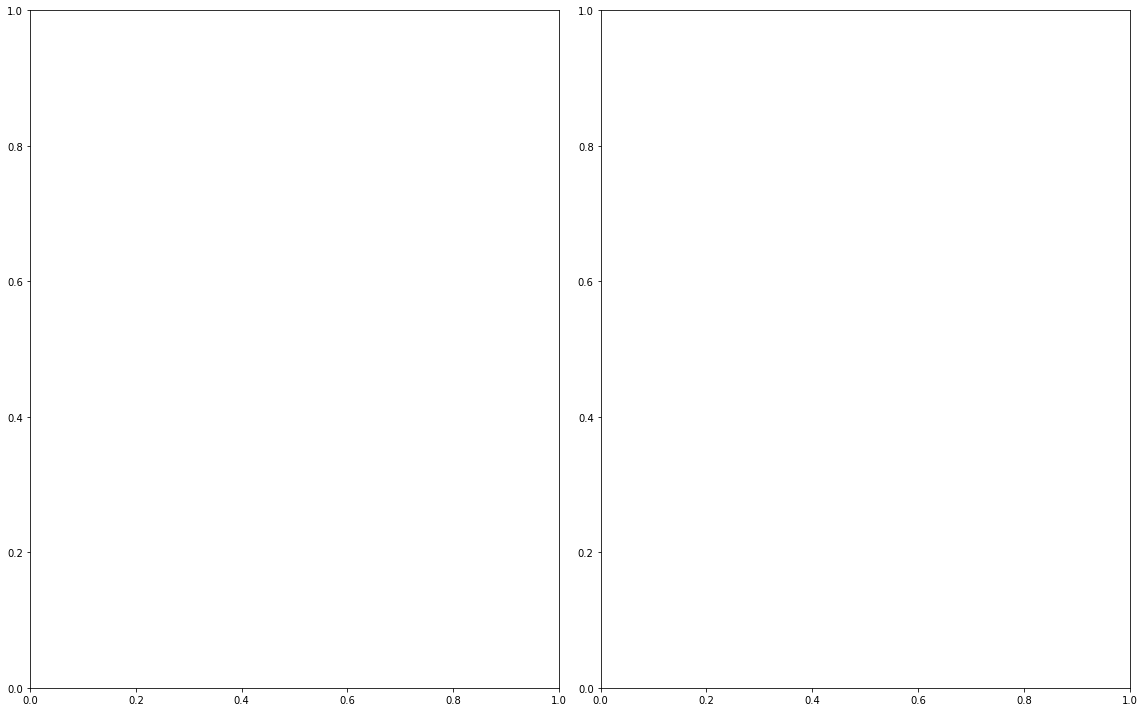

In [10]:
interact(GP_tune, **controls);